<a href="https://colab.research.google.com/github/kodai-utsunomiya/memorization-and-generalization/blob/main/Mechanism_of_feature_learning_in_deep_fully_connected_networks_and_kernel_machines_that_recursively_learn_features_Grokking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

（cpuでは厳しい）

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# classic_kernel

### <font color= “green”> 1. ユークリッド距離（Euclidean Distance）</font>

#### `euclidean_distances` 関数

この関数は，サンプル点集合 $X \in \mathbb{R}^{n \times d}$ とセンター点集合 $C \in \mathbb{R}^{m \times d}$ の間のユークリッド距離を計算する．サンプル点 $X$ の $i$ 番目の点とセンター点 $C$ の $j$ 番目の点との距離は次のように計算される．

1. **ノルムの計算**：

   サンプル点のノルムの計算：
   $$
   \|X_i\|^2 = X_i \cdot X_i^T = \sum_{k=1}^d X_{ik}^2
   $$
   センター点のノルムの計算：
   $$
   \|C_j\|^2 = C_j \cdot C_j^T = \sum_{k=1}^d C_{jk}^2
   $$

2. **距離の計算**：

   ユークリッド距離の平方：
   $$
   \text{dist}(X_i, C_j)^2 = \|X_i\|^2 + \|C_j\|^2 - 2 \langle X_i, C_j \rangle
   $$

   ここで $\langle X_i, C_j \rangle$ は内積であり，
   $$
   \langle X_i, C_j \rangle = X_i \cdot C_j^T
   $$

   ノルムの計算が行われているが，もし `squared=False` の場合には，平方根を取ることでユークリッド距離を計算する．

#### `euclidean_distances_M` 関数

この関数は，ユークリッド距離の計算を一般化したもので，距離計算に対して行列 $M$ を適用する．

1. **ノルムの計算**：

   サンプル点に対して行列 $M$ を使ったノルム：
   $$
   \|X_i\|_M^2 = (X_i M) \cdot X_i^T = \sum_{k=1}^d (X_{ik} (M X_i)_k)^2
   $$
   センター点に対して行列 $M$ を使ったノルム：
   $$
   \|C_j\|_M^2 = (C_j M) \cdot C_j^T = \sum_{k=1}^d (C_{jk} (M C_j)_k)^2
   $$

2. **距離の計算**：

   一般化された距離の平方：
   $$
   \text{dist}_M(X_i, C_j)^2 = \|X_i\|_M^2 + \|C_j\|_M^2 - 2 \langle X_i M, C_j M \rangle
   $$
   ここで $\langle X_i M, C_j M \rangle$ は内積であり，
   $$
   \langle X_i M, C_j M \rangle = X_i \cdot (M C_j)^T
   $$

   `squared=False` の場合には平方根を取ることでユークリッド距離を計算する．

### <font color= “green”> 2. ガウスカーネル（Gaussian Kernel）</font>

#### `gaussian` 関数

ガウスカーネルは，サンプル点とセンター点との間の距離に基づいて次のように定義される：

$$
K(X_i, C_j) = \exp\left(-\frac{\text{dist}(X_i, C_j)^2}{2 \sigma^2}\right)
$$

ここで $\sigma$ はバンド幅であり，`euclidean_distances` 関数で計算された距離に基づいてカーネル行列を計算する．

### <font color= “green”> 3. ラプラシアンカーネル（Laplacian Kernel）</font>

#### `laplacian` 関数

ラプラシアンカーネルは，ユークリッド距離の絶対値に基づいて次のように定義される：

$$
K(X_i, C_j) = \exp\left(-\frac{\|\text{dist}(X_i, C_j)\|}{\sigma}\right)
$$

ここで $\sigma$ はバンド幅であり，`euclidean_distances` 関数で計算された距離（平方根を取ったもの）に基づいてカーネル行列を計算する．

#### `laplacian_M` 関数

行列 $M$ を使用して一般化されたラプラシアンカーネルを計算する：

$$
K(X_i, C_j) = \exp\left(-\frac{\|\text{dist}_M(X_i, C_j)\|}{\sigma}\right)
$$

### <font color= “green”> 4. ディスパーサルカーネル（Dispersal Kernel）</font>

#### `dispersal` 関数

ディスパーサルカーネルは，ユークリッド距離の $\gamma/2$ 乗に基づいて次のように定義される：

$$
K(X_i, C_j) = \exp\left(-\frac{\text{dist}(X_i, C_j)^{\gamma/2}}{\sigma}\right)
$$

ここで $\sigma$ はバンド幅，$\gamma$ はディスパーサルファクターであり，`euclidean_distances` 関数で計算された距離に基づいてカーネル行列を計算する．

In [2]:
'''Implementation of kernel functions.'''

import torch


def euclidean_distances(samples, centers, squared=True):
    samples_norm = torch.sum(samples**2, dim=1, keepdim=True)
    if samples is centers:
        centers_norm = samples_norm
    else:
        centers_norm = torch.sum(centers**2, dim=1, keepdim=True)
    centers_norm = torch.reshape(centers_norm, (1, -1))

    distances = samples.mm(torch.t(centers))
    distances.mul_(-2)
    distances.add_(samples_norm)
    distances.add_(centers_norm)
    # print(centers_norm.size(), samples_norm.size(), distances.size())
    if not squared:
        distances.clamp_(min=0)
        distances.sqrt_()

    return distances


def euclidean_distances_M(samples, centers, M, squared=True):

    samples_norm = (samples @ M)  * samples
    samples_norm = torch.sum(samples_norm, dim=1, keepdim=True)

    if samples is centers:
        centers_norm = samples_norm
    else:
        centers_norm = (centers @ M) * centers
        centers_norm = torch.sum(centers_norm, dim=1, keepdim=True)

    centers_norm = torch.reshape(centers_norm, (1, -1))

    distances = samples.mm(M @ torch.t(centers))
    distances.mul_(-2)
    distances.add_(samples_norm)
    distances.add_(centers_norm)

    if not squared:
        distances.clamp_(min=0)
        distances.sqrt_()

    return distances


def gaussian(samples, centers, bandwidth):
    '''Gaussian kernel.

    Args:
        samples: of shape (n_sample, n_feature).
        centers: of shape (n_center, n_feature).
        bandwidth: kernel bandwidth.

    Returns:
        kernel matrix of shape (n_sample, n_center).
    '''
    assert bandwidth > 0
    kernel_mat = euclidean_distances(samples, centers)
    kernel_mat.clamp_(min=0)
    gamma = 1. / (2 * bandwidth ** 2)
    kernel_mat.mul_(-gamma)
    kernel_mat.exp_()

    #print(samples.size(), centers.size(),
    #      kernel_mat.size())
    return kernel_mat


def laplacian(samples, centers, bandwidth):
    '''Laplacian kernel.

    Args:
        samples: of shape (n_sample, n_feature).
        centers: of shape (n_center, n_feature).
        bandwidth: kernel bandwidth.

    Returns:
        kernel matrix of shape (n_sample, n_center).
    '''
    assert bandwidth > 0
    kernel_mat = euclidean_distances(samples, centers, squared=False)
    kernel_mat.clamp_(min=0)
    gamma = 1. / bandwidth
    kernel_mat.mul_(-gamma)
    kernel_mat.exp_()
    return kernel_mat



def laplacian_M(samples, centers, bandwidth, M):
    assert bandwidth > 0
    kernel_mat = euclidean_distances_M(samples, centers, M, squared=False)
    kernel_mat.clamp_(min=0)
    gamma = 1. / bandwidth
    kernel_mat.mul_(-gamma)
    kernel_mat.exp_()
    return kernel_mat


def dispersal(samples, centers, bandwidth, gamma):
    '''Dispersal kernel.

    Args:
        samples: of shape (n_sample, n_feature).
        centers: of shape (n_center, n_feature).
        bandwidth: kernel bandwidth.
        gamma: dispersal factor.

    Returns:
        kernel matrix of shape (n_sample, n_center).
    '''
    assert bandwidth > 0
    kernel_mat = euclidean_distances(samples, centers)
    kernel_mat.pow_(gamma / 2.)
    kernel_mat.mul_(-1. / bandwidth)
    kernel_mat.exp_()
    return kernel_mat

# neural_model

### 1. ニューラルネットワーク

#### クラス `Nonlinearity`

`Nonlinearity` クラスは ReLU（Rectified Linear Unit）活性化関数を定義する．具体的には，入力 $x \in \mathbb{R}^d$ に対して以下のように計算される：

$$
\text{ReLU}(x) = \max(0, x)
$$

#### クラス `Net`

このクラスはニューラルネットワークを定義する．ネットワークの構造は次の通り：

1. **初期化**：

   - <font color="red">`dim` </font>は<font color="red">入力次元数</font>であり，
   - <font color="red">`num_classes`</font> は<font color="red">出力クラスの数</font>である（デフォルトは $2$）．
   - <font color="red">`k` </font>は<font color="red">隠れ層のノード数</font>であり，ここでは $1024$ である．

   ネットワークの層は次のように構成されている：

   1. **線形変換**：

      最初の線形層は入力から隠れ層への変換を行う．ここで $W_1 \in \mathbb{R}^{k \times \text{dim}}$ は重み行列，$b_1 \in \mathbb{R}^k$ はバイアス項（バイアスはここでは $False$ に設定されているため，$b_1$ はゼロベクトルとして扱われる）である．入力 $x \in \mathbb{R}^\text{dim}$ に対して，出力 $h_1 \in \mathbb{R}^k$ は次のように計算される：

      $$
      h_1 = W_1 x
      $$

   2. **非線形変換**：

      次に ReLU 活性化関数を適用する．これは要素ごとの非線形変換であり，以下のように計算される：

      $$
      h_1' = \text{ReLU}(h_1) = \max(0, h_1)
      $$

   3. **第二の線形変換**：

      次の線形層は隠れ層から再び隠れ層への変換を行う．ここで $W_2 \in \mathbb{R}^{k \times k}$ は重み行列，$b_2 \in \mathbb{R}^k$ はバイアス項であり（バイアスはここでも $False$ に設定されている），出力 $h_2 \in \mathbb{R}^k$ は次のように計算される：

      $$
      h_2 = W_2 h_1'
      $$

      再び ReLU 活性化関数が適用される：

      $$
      h_2' = \text{ReLU}(h_2) = \max(0, h_2)
      $$

   4. **最終の線形変換**：

      最後の線形層は隠れ層から出力層への変換を行う．ここで $W_3 \in \mathbb{R}^{\text{num_classes} \times k}$ は重み行列，$b_3 \in \mathbb{R}^{\text{num_classes}}$ はバイアス項（ここでも $False$ に設定されている），出力 $y \in \mathbb{R}^{\text{num_classes}}$ は次のように計算される：

      $$
      y = W_3 h_2'
      $$

   以上により，最終的な出力 $y$ はニューラルネットワークの出力となる．

### まとめ

全体として，ニューラルネットワークは次のような数式で表される：

1. 初期線形層：
   $$
   h_1 = W_1 x
   $$

2. ReLU 活性化：
   $$
   h_1' = \text{ReLU}(h_1)
   $$

3. 第二の線形層：
   $$
   h_2 = W_2 h_1'
   $$

4. 再び ReLU 活性化：
   $$
   h_2' = \text{ReLU}(h_2)
   $$

5. 最終の線形層：
   $$
   y = W_3 h_2'
   $$

ここで，$W_1$，$W_2$，$W_3$ は各線形層の重み行列であり，バイアス項はすべてゼロベクトルとして扱われている．

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable, Function
import torch.optim as optim
from torchvision import models
from torch.nn.functional import upsample
from copy import deepcopy
import torch.nn.functional as F


class Nonlinearity(torch.nn.Module):
    def __init__(self):
        super(Nonlinearity, self).__init__()

    def forward(self, x):
        return F.relu(x)


class Net(nn.Module):

    def __init__(self, dim, num_classes=2):
        super(Net, self).__init__()
        bias = False
        k = 1024
        self.dim = dim
        self.width = k
        self.first = nn.Linear(dim, k, bias=bias)
        self.fc = nn.Sequential(Nonlinearity(),
                                nn.Linear(k, k, bias=bias),
                                Nonlinearity(),
                                nn.Linear(k, num_classes, bias=bias))

    def forward(self, x):
        return self.fc(self.first(x))

# trainer

ニューラルネットワークのトレーニング，検証，テストを行うためのものである．

#### 1. `visualize_M(M, idx)`

この関数は行列 $M$ の可視化を行う．

1. **行列の分割と対角成分の抽出**：

   行列 $M$ は $d \times d$ の行列であり，$d$ は $3 \times SIZE^2$ に等しい．ここで $SIZE = \sqrt{\frac{d}{3}}$ である．行列 $M$ を以下のように分割する：
   - $F_1$ は $M$ の最初の $SIZE^2 \times SIZE^2$ 部分の対角成分を取り出し，$SIZE \times SIZE$ 行列に変換する．
   - $F_2$ は次の $SIZE^2 \times SIZE^2$ 部分の対角成分を処理する．
   - $F_3$ は残りの部分の対角成分を処理する．

   数式で示すと：
   $$
   F_1 = \text{diag}(M[:SIZE^2, :SIZE^2]) \text{ を } \text{reshape}(SIZE, SIZE)
   $$
   $$
   F_2 = \text{diag}(M[SIZE^2:2 \times SIZE^2, SIZE^2:2 \times SIZE^2]) \text{ を } \text{reshape}(SIZE, SIZE)
   $$
   $$
   F_3 = \text{diag}(M[2 \times SIZE^2:, 2 \times SIZE^2:]) \text{ を } \text{reshape}(SIZE, SIZE)
   $$

2. **正規化と可視化**：

   行列 $F$ をスタックし，最小値と最大値で正規化する：
   $$
   F = \text{stack}(F_1, F_2, F_3)
   $$
   $$
   F_{\text{norm}} = \frac{F - F_{\text{min}}}{F_{\text{max}} - F_{\text{min}}}
   $$

   正規化された行列を画像として保存する：
   $$
   \text{plt.imshow}(F_{\text{norm}})
   $$

#### 2. `train_network(train_loader, val_loader, test_loader, num_classes=2, name=None, save_frames=False)`

この関数はネットワークのトレーニング，検証，テストを行う．

1. **ネットワークの初期化**：

   ネットワーク $f_\theta$ を以下のように定義する：
   $$
   f_\theta(x) = \text{fc}(\text{Nonlinearity}(\text{first}(x)))
   $$
   ここで $\text{fc}$ は全結合層のシーケンスであり，$\text{first}$ は最初の線形層である．

2. **パラメータ数の計算**：

   ネットワークのパラメータ数は以下のように計算する：
   $$
   \text{params} = \sum_{i=1}^n \prod_{j=1}^{d_i} \text{size}_{i,j}
   $$
   ここで $d_i$ は $i$ 番目のパラメータの次元数である．

3. **トレーニングループ**：

   - **エポックごとの処理**：
     - フレームを保存する場合，最初のパラメータの行列 $M$ を取り出し，可視化する．
     - エポック $i = 0$ または $i = 1$ の場合，モデルを保存する．
   
   - **トレーニング，検証，テスト**：
     - トレーニング損失 $L_{\text{train}}$ を計算する：
       $$
       L_{\text{train}} = \frac{1}{N_{\text{train}}} \sum_{i=1}^{N_{\text{train}}} \| \hat{Y}^{(i)} - Y^{(i)} \|^2
       $$
     - 検証損失 $L_{\text{val}}$ を計算する：
       $$
       L_{\text{val}} = \frac{1}{N_{\text{val}}} \sum_{i=1}^{N_{\text{val}}} \| \hat{Y}^{(i)} - Y^{(i)} \|^2
       $$
     - テスト損失 $L_{\text{test}}$ を計算する：
       $$
       L_{\text{test}} = \frac{1}{N_{\text{test}}} \sum_{i=1}^{N_{\text{test}}} \| \hat{Y}^{(i)} - Y^{(i)} \|^2
       $$

   - **精度の計算**：
     - トレーニング精度 $A_{\text{train}}$，検証精度 $A_{\text{val}}$，およびテスト精度 $A_{\text{test}}$ を計算する：
       $$
       A = \frac{\text{number of correct predictions}}{\text{total number of samples}} \times 100
       $$

#### 3. `get_data(loader)`

この関数はデータローダから全データを取得する．

1. **データの収集**：

   バッチから入力 $X$ とラベル $y$ を取得し，結合する：
   $$
   X = \text{torch.cat}(X, \text{dim}=0)
   $$
   $$
   y = \text{torch.cat}(y, \text{dim}=0)
   $$

#### 4. `train_step(net, optimizer, train_loader, save_frames=False)`

この関数はトレーニングステップを実行する．

1. **入力とラベルの取得**：

   バッチから入力 $X$ とラベル $Y$ を取得する．

2. **フォワードパスと損失計算**：

   ネットワークを用いてフォワードパスを実行し，損失を計算する：
   $$
   \hat{Y} = f_\theta(X)
   $$
   $$
   \text{Loss} = \frac{1}{N} \sum_{i=1}^N \| \hat{Y}^{(i)} - Y^{(i)} \|^2
   $$

3. **バックプロパゲーションとパラメータ更新**：

   勾配を計算し，パラメータを更新する：
   $$
   \nabla_\theta \text{Loss} \quad \text{を計算し，} \quad \theta \leftarrow \theta - \eta \nabla_\theta \text{Loss}
   $$

#### 5. `val_step(net, val_loader)`

この関数は検証ステップを実行する．

1. **入力とラベルの取得**：

   バッチから入力 $X$ とラベル $Y$ を取得する．

2. **フォワードパスと損失計算**：

   ネットワークを用いてフォワードパスを実行し，損失を計算する：
   $$
   \hat{Y} = f_\theta(X)
   $$
   $$
   \text{Loss} = \frac{1}{N} \sum_{i=1}^N \| \hat{Y}^{(i)} - Y^{(i)} \|^2
   $$

#### 6. `get_acc(net, loader)`

この関数は精度を計算する．

1. **入力とラベルの取得**：

   バッチから入力 $X$ とラベル $Y$ を取得する．

2. **フォワードパスと予測**：

   ネットワークを用いてフォワードパスを実行し，予測 $\hat{Y}$ を得る：
   $$
   \hat{Y} = f_\theta(X)
   $$
   予測ラベルを計算する：
   $$
   \hat{y} = \text{argmax}(\hat{Y}, \text{dim}=-1)
   $$

3. **精度の計算**：

   正解率を計算する：
   $$
   A = \frac{1}{N} \sum_{i=1}^N \mathbf{1}(\hat{y}_i = y_i) \times 100
   $$

In [4]:
import torch
from torch.autograd import Variable
import torch.optim as optim
import time
# import neural_model
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np


def visualize_M(M, idx):
    d, _ = M.shape
    SIZE = int(np.sqrt(d // 3))
    F1 = np.diag(M[:SIZE**2, :SIZE**2]).reshape(SIZE, SIZE)
    F2 = np.diag(M[SIZE**2:2*SIZE**2, SIZE**2:2*SIZE**2]).reshape(SIZE, SIZE)
    F3 = np.diag(M[2*SIZE**2:, 2*SIZE**2:]).reshape(SIZE, SIZE)
    F = np.stack([F1, F2, F3])
    print(F.shape)
    F = (F - F.min()) / (F.max() - F.min())
    F = np.rollaxis(F, 0, 3)
    plt.imshow(F)
    plt.axis('off')
    plt.savefig('./video_logs/' + str(idx).zfill(6) + '.png',
                bbox_inches='tight', pad_inches = 0)
    return F


def train_network(train_loader, val_loader, test_loader,
                  num_classes=2, name=None,
                  save_frames=False):


    for idx, batch in enumerate(train_loader):
        inputs, labels = batch
        _, dim = inputs.shape
        break

    # neural_model.Net
    net = Net(dim, num_classes=num_classes)

    params = 0
    for idx, param in enumerate(list(net.parameters())):
        size = 1
        for idx in range(len(param.size())):
            size *= param.size()[idx]
            params += size
    print("NUMBER OF PARAMS: ", params)

    optimizer = torch.optim.SGD(net.parameters(), lr=.1)

    net.to(device)
    num_epochs = 501
    best_val_acc = 0
    best_test_acc = 0
    best_val_loss = np.float("inf")
    best_test_loss = 0

    for i in range(num_epochs):
        if save_frames:
            net.cpu()
            for idx, p in enumerate(net.parameters()):
                if idx == 0:
                    M = p.data.numpy()
            M = M.T @ M
            visualize_M(M, i)
            net.to(device)

        if i == 0 or i == 1:
            net.cpu()
            d = {}
            d['state_dict'] = net.state_dict()
            if name is not None:
                torch.save(d, 'nn_models/' + name + '_trained_nn_' + str(i) + '.pth')
            else:
                torch.save(d, 'nn_models/trained_nn.pth')
            net.to(device)

        train_loss = train_step(net, optimizer, train_loader, save_frames=save_frames)
        val_loss = val_step(net, val_loader)
        test_loss = val_step(net, test_loader)
        train_acc = get_acc(net, train_loader)
        val_acc = get_acc(net, val_loader)
        test_acc = get_acc(net, test_loader)

        if val_acc >= best_val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
            net.cpu()
            d = {}
            d['state_dict'] = net.state_dict()
            if name is not None:
                torch.save(d, 'nn_models/' + name + '_trained_nn.pth')
            else:
                torch.save(d, 'nn_models/trained_nn.pth')
            net.to(device)

        if val_loss <= best_val_loss:
            best_val_loss = val_loss
            best_test_loss = test_loss

        print("Epoch: ", i,
              "Train Loss: ", train_loss, "Test Loss: ", test_loss,
              "Train Acc: ", train_acc, "Test Acc: ", test_acc,
              "Best Val Acc: ", best_val_acc, "Best Val Loss: ", best_val_loss,
              "Best Test Acc: ", best_test_acc, "Best Test Loss: ", best_test_loss)


def get_data(loader):
    X = []
    y = []
    for idx, batch in enumerate(loader):
        inputs, labels = batch
        X.append(inputs)
        y.append(labels)
    return torch.cat(X, dim=0), torch.cat(y, dim=0)


def train_step(net, optimizer, train_loader, save_frames=False):
    net.train()
    start = time.time()
    train_loss = 0.

    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        targets = labels
        output = net(Variable(inputs))
        target = Variable(targets)
        loss = torch.mean(torch.pow(output - target, 2))
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().data.numpy() * len(inputs)
    end = time.time()
    print("Time: ", end - start)
    train_loss = train_loss / len(train_loader.dataset)
    return train_loss

def val_step(net, val_loader):
    net.eval()
    val_loss = 0.

    for batch_idx, batch in enumerate(val_loader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        targets = labels
        with torch.no_grad():
            output = net(Variable(inputs))
            target = Variable(targets)
        loss = torch.mean(torch.pow(output - target, 2))
        val_loss += loss.cpu().data.numpy() * len(inputs)
    val_loss = val_loss / len(val_loader.dataset)
    return val_loss


def get_acc(net, loader):
    net.eval()
    count = 0
    for batch_idx, batch in enumerate(loader):
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            output = net(Variable(inputs).cuda())
            target = Variable(targets).cuda()

        preds = torch.argmax(output, dim=-1)
        labels = torch.argmax(target, dim=-1)

        count += torch.sum(labels == preds).cpu().data.numpy()
    return count / len(loader.dataset) * 100

# rfm

In [5]:
!pip install hickle==5.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 2.9 MB/s eta 0:00:00


#### 1. `laplace_kernel_M(pair1, pair2, bandwidth, M)`

この関数は、ラプラシアンカーネルを計算するために使用される．

1. **ラプラシアンカーネル**：

   ラプラシアンカーネルの定義は次のようになる：
   $$
   K_{ij} = \exp \left( - \frac{\| x_i - x_j \|_2}{\text{bandwidth}} \right)
   $$
   ここで $\| \cdot \|_2$ はユークリッド距離，$\text{bandwidth}$ はカーネルの帯域幅である．このカーネルは $M$ 行列に基づいて計算される．

#### 2. `get_grads(X, sol, L, P, batch_size=2)`

この関数は、勾配行列 $M$ を計算する．

1. **カーネル行列の計算**：

   カーネル行列 $K$ は、データ行列 $X$ とサンプル行列 $x$ の間で計算される：
   $$
   K_{ij} = K(x_i, x_j) = \frac{1}{d_{ij}} \exp \left( - \frac{\| x_i - x_j \|_2}{L} \right)
   $$
   ここで $d_{ij}$ はユークリッド距離であり，$L$ は帯域幅である．

2. **勾配計算**：

   - **ステップ 1**:
     $$
     \text{step1} = a_1 \cdot (X P)^T
     $$
     ここで $a_1$ は $sol^T$ をトーチテンソルに変換したものであり，$X P$ はデータ行列 $X$ に行列 $P$ を掛けたものである．

   - **ステップ 2**:
     $$
     \text{step2} = K^T \cdot \text{step1}
     $$

   - **ステップ 3**:
     $$
     \text{step3} = a_2 \cdot K
     $$
     ここで $a_2$ は $sol$ である．

   勾配行列 $G$ の計算は次のようになる：
   $$
   G = -\frac{\text{step2} - \text{step3}}{L}
   $$

   最後に、バッチサイズごとに勾配を分割し，行列 $M$ を計算する：
   $$
   M = \frac{1}{N_{\text{batch}}} \sum_{i=1}^{N_{\text{batch}}} \left( \text{grad}^T \cdot \text{grad} \right)
   $$

#### 3. `rfm(train_loader, val_loader, test_loader, iters=3, name=None, batch_size=2, reg=1e-3, train_acc=False)`

この関数は、ラプラシアンカーネル回帰のトレーニングと評価を行う．

1. **トレーニングと評価の反復**：

   - **カーネル行列の計算**：
     $$
     K_{\text{train}} = K(X_{\text{train}}, X_{\text{train}}, L, M)
     $$

   - **線形方程式の解法**：

     ラプラシアンカーネル行列 $K_{\text{train}}$ と正則化項で線形方程式を解く：
     $$
     \text{sol} = (K_{\text{train}} + \text{reg} \cdot I)^{-1} y_{\text{train}}
     $$

   - **予測の計算**：
     テストデータに対する予測は次のように計算される：
     $$
     \text{preds} = \text{sol} \cdot K_{\text{test}}
     $$

   - **MSE と精度の計算**：

     予測と実際のラベルの間の平均二乗誤差（MSE）は次のように計算される：
     $$
     \text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \| \text{preds_i} - y_{\text{test}, i} \|^2
     $$

     精度は次のように計算される：
     $$
     \text{Acc} = \frac{\text{number of correct predictions}}{\text{total number of samples}} \times 100
     $$

   - **勾配行列 $M$ の更新**：
     更新後の勾配行列は次のように計算される：
     $$
     M = \text{get\_grads}(X_{\text{train}}, \text{sol}, L, M, \text{batch\_size})
     $$

   - **最終評価**：

     トレーニングとテストデータに対する最終的な MSE と精度を計算し，出力する．

#### 4. `get_data(loader)`

この関数はデータローダからデータを取得し，結合する．

1. **データの収集**：
   データローダから全てのバッチを収集し，データ行列 $X$ とラベル $y$ を結合する：
   $$
   X = \text{torch.cat}(X, \text{dim}=0)
   $$
   $$
   y = \text{torch.cat}(y, \text{dim}=0)
   $$

In [6]:
import numpy as np
import torch
from numpy.linalg import solve
# import classic_kernel
from tqdm import tqdm
import hickle

def laplace_kernel_M(pair1, pair2, bandwidth, M):
    # classic_kernel.laplacian_M
    return laplacian_M(pair1, pair2, bandwidth, M)


def get_grads(X, sol, L, P, batch_size=2):
    M = 0.

    num_samples = 20000
    indices = np.random.randint(len(X), size=num_samples)

    if len(X) > len(indices):
        x = X[indices, :]
    else:
        x = X

    K = laplace_kernel_M(X, x, L, P)

    # classic_kernel.euclidean_distances_M
    dist = euclidean_distances_M(X, x, P, squared=False)
    dist = torch.where(dist < 1e-10, torch.zeros(1).float(), dist)

    K = K / dist
    K[K == float("Inf")] = 0.

    a1 = torch.from_numpy(sol.T).float()
    n, d = X.shape
    n, c = a1.shape
    m, d = x.shape

    a1 = a1.reshape(n, c, 1)
    X1 = (X @ P).reshape(n, 1, d)
    step1 = a1 @ X1
    del a1, X1
    step1 = step1.reshape(-1, c * d)

    step2 = K.T @ step1
    del step1

    step2 = step2.reshape(-1, c, d)

    a2 = torch.from_numpy(sol).float()
    step3 = (a2 @ K).T

    del K, a2

    step3 = step3.reshape(m, c, 1)
    x1 = (x @ P).reshape(m, 1, d)
    step3 = step3 @ x1

    G = (step2 - step3) * -1 / L

    M = 0.

    bs = batch_size
    batches = torch.split(G, bs)
    for i in tqdm(range(len(batches))):
        grad = batches[i]
        if torch.cuda.is_available():
            grad = grad.cuda()
        gradT = torch.transpose(grad, 1, 2)
        M += torch.sum(gradT @ grad, dim=0).cpu()
        del grad, gradT
    torch.cuda.empty_cache()
    M /= len(G)
    M = M.numpy()

    return M


def rfm(train_loader, val_loader, test_loader,
        iters=3, name=None, batch_size=2, reg=1e-3,
        train_acc=False):

    L = 10

    X_train, y_train = get_data(train_loader)
    X_val, y_val = get_data(val_loader)
    X_test, y_test = get_data(test_loader)

    n, d = X_train.shape

    M = np.eye(d, dtype='float32')

    for i in range(iters):
        K_train = laplace_kernel_M(X_train, X_train, L, torch.from_numpy(M)).numpy()
        sol = solve(K_train + reg * np.eye(len(K_train)), y_train).T

        if train_acc:
            preds = (sol @ K_train).T
            y_pred = torch.from_numpy(preds)
            preds = torch.argmax(y_pred, dim=-1)
            labels = torch.argmax(y_train, dim=-1)
            count = torch.sum(labels == preds).numpy()
            print("Round " + str(i) + " Train Acc: ", count / len(labels))

        K_test = laplace_kernel_M(X_train, X_test, L, torch.from_numpy(M)).numpy()
        preds = (sol @ K_test).T
        print("Round " + str(i) + " MSE: ", np.mean(np.square(preds - y_test.numpy())))
        y_pred = torch.from_numpy(preds)
        preds = torch.argmax(y_pred, dim=-1)
        labels = torch.argmax(y_test, dim=-1)
        count = torch.sum(labels == preds).numpy()
        print("Round " + str(i) + " Acc: ", count / len(labels))

        M  = get_grads(X_train, sol, L, torch.from_numpy(M), batch_size=batch_size)
        if name is not None:
            hickle.dump(M, 'saved_Ms/M_' + name + '_' + str(i) + '.h')

    K_train = laplace_kernel_M(X_train, X_train, L, torch.from_numpy(M)).numpy()
    sol = solve(K_train + reg * np.eye(len(K_train)), y_train).T
    K_test = laplace_kernel_M(X_train, X_test, L, torch.from_numpy(M)).numpy()
    preds = (sol @ K_test).T
    mse = np.mean(np.square(preds - y_test.numpy()))
    print("Final MSE: ", mse)
    y_pred = torch.from_numpy(preds)
    preds = torch.argmax(y_pred, dim=-1)
    labels = torch.argmax(y_test, dim=-1)
    count = torch.sum(labels == preds).numpy()
    print(" Final Acc: ", count / len(labels))
    return mse


def get_data(loader):
    X = []
    y = []
    for idx, batch in enumerate(loader):
        inputs, labels = batch
        X.append(inputs)
        y.append(labels)
    return torch.cat(X, dim=0), torch.cat(y, dim=0)

In [7]:
!pip install visdom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408195 sha256=52a9fc624b2a37bf591bc5c4591bf9ca4c353bba33999be75e5b105d7935ff16
  Stored in directory: /root/.cache/pip/wheels/42/29/49/5bed207bac4578e4d2c0c5fc0226bfd33a7e2953ea56356855
Successfully built visdom


# grokking_main

### 1. データ準備

#### 1.1. `one_hot_data(dataset, num_samples=-1)`

この関数は，データセットを前処理し，ワンホットエンコーディングを行う．

- **ラベルのワンホットエンコーディング**：
  
  各ラベル $i$ に対して，ワンホットベクトル $v_i$ を定義する．
  $$
  v_i[j] = \begin{cases}
  1 & \text{if } j = i \\
  0 & \text{otherwise}
  \end{cases}
  $$
  ここで $i$ はクラスインデックス，$j$ はベクトルのインデックスである．

- **サブセットの作成**：

  データセットから，ラベルが $0$ または $9$ のサンプルを選び，指定された数 ($num\_samples$) だけを使用する．

- **データの調整**：

  画像の一部をゼロにすることでデータを調整する：
  $$
  x_{\text{adjusted}} = \begin{cases}
  x_{\text{original}} & \text{if label } = 0 \\
  x_{\text{original}} \text{ with specific region set to 1} & \text{if label } = 9
  \end{cases}
  $$

#### 1.2. `split(trainset, p=.8)`

この関数はデータセットをトレーニングセットとバリデーションセットに分割する．

- **データの分割**：

  データセット $D$ をトレーニングセット $D_{\text{train}}$ とバリデーションセット $D_{\text{val}}$ に分ける：
  $$
  D_{\text{train}}, D_{\text{val}} = \mathrm{train\_test\_split}(D, \mathrm{train\_size}=p)
  $$
  ここで $p$ はトレーニングデータの割合である．

### 2. モデルとカーネルのロード

#### 2.1. `load_from_net(SIZE=64, path='./nn_models/trained_nn.pth')`

この関数は，保存されたニューラルネットワークの重みを読み込み，カーネル行列 $M$ を計算する．

- **重み行列 $M$ の計算**：

  ニューラルネットワークの重み行列 $M$ を取得し，転置してから内積を計算する：
  $$
  M = (W^T W)
  $$
  ここで $W$ はネットワークの重み行列であり，$M$ は最終的なカーネル行列である．

### 3. メイン関数の処理

#### 3.1. データのローディングとトレーニング

- **データローディング**：

  データローダーを用いてトレーニングセット，バリデーションセット，テストセットをロードする：
  $$
  \text{trainloader} = \mathrm{torch.utils.data.DataLoader}(D_{\mathrm{train}}, \mathrm{batch\_size}=1024)
  $$
  $$
  \text{valloader} = \mathrm{torch.utils.data.DataLoader}(D_{\mathrm{val}}, \mathrm{batch\_size}=100)
  $$
  $$
  \text{testloader} = \mathrm{torch.utils.data.DataLoader}(D_{\mathrm{test}}, \mathrm{batch\_size}=1024)
  $$

- **ラプラシアンカーネル回帰のトレーニングと評価**：

  `rfm` 関数を呼び出して，ラプラシアンカーネル回帰をトレーニングする：
  $$
  \text{rfm}( \text{trainloader}, \text{valloader}, \text{testloader}, \text{iters}=5, \mathrm{train\_acc}=True, \text{reg}=1e-3 )
  $$

  ここで，`rfm` 関数内でラプラシアンカーネル $K$ を計算し，回帰モデルをトレーニングし，評価を行う．

- **ニューラルネットワークのトレーニング**：

  `train_network` 関数を呼び出して，ニューラルネットワークをトレーニングする：
  $$
  \mathrm{train\_network}( \text{trainloader}, \text{valloader}, \text{testloader}, \text{name}='grokking' )
  $$

### 4. 要点

1. **ラベルのワンホットエンコーディング**：
   $$
   v_i[j] = \begin{cases}
   1 & \text{if } j = i \\
   0 & \text{otherwise}
   \end{cases}
   $$

2. **カーネル行列の計算**：
   $$
   K_{ij} = \frac{1}{d_{ij}} \exp \left( - \frac{\| x_i - x_j \|_2}{L} \right)
   $$

3. **勾配行列 $M$ の計算**：
   $$
   M = \frac{1}{N_{\text{batch}}} \sum_{i=1}^{N_{\text{batch}}} \left( \text{grad}^T \cdot \text{grad} \right)
   $$

4. **回帰モデルの評価**：
   平均二乗誤差（MSE）は次のように計算される：
   $$
   \text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \| \text{preds}_i - y_{\text{test}, i} \|^2
   $$
   精度は次のように計算される：
   $$
   \text{Acc} = \frac{\text{number of correct predictions}}{\text{total number of samples}} \times 100
   $$

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
# import trainer as t
from torch.utils.data import Dataset
import random
import torch.backends.cudnn as cudnn
# import rfm
import numpy as np
from sklearn.model_selection import train_test_split
from torch.linalg import norm
from random import randint
import visdom
# import eigenpro_rtfm as erfm
import hickle
# import neural_model

vis = visdom.Visdom('http://127.0.0.1', use_incoming_socket=False)
vis.close(env='main')

SEED = 5636
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)

SIZE = 96
h, w = SIZE, SIZE
locationx = np.array([randint(0, h-1) for i in range(10)], dtype='int')
locationy = np.array([randint(0, w-1) for i in range(10)], dtype='int')

shiftx_l = np.array(locationx - 2, dtype='int')
shiftx_r = np.array(locationx + 3, dtype='int')
shifty_l = np.array(locationy - 2, dtype='int')
shifty_r = np.array(locationy + 3, dtype='int')


def one_hot_data(dataset, num_samples=-1):
    labelset = {}
    for i in range(10):
        one_hot = torch.zeros(10)
        one_hot[i] = 1
        labelset[i] = one_hot

    subset = [(ex, label) for idx, (ex, label) in enumerate(dataset) \
              if idx < num_samples and label == 0 or label == 9]

    adjusted = []

    count = 0
    for idx, (ex, label) in enumerate(subset):
        ex[:, 2:7, 7:12] = 0.
        if label == 9:
            count += 1
            ex[:, 2:7, 7:12] = 1.
        if idx < 10:
            vis.image(ex)
        ex = ex.flatten()
        adjusted.append((ex, labelset[label]))
    return adjusted

def split(trainset, p=.8):
    train, val = train_test_split(trainset, train_size=p)
    return train, val

def load_from_net(SIZE=64, path='./nn_models/trained_nn.pth'):
    dim = 3 * SIZE * SIZE
    # neural_model.Net
    net = Net(dim, num_classes=10)

    d = torch.load(path)
    net.load_state_dict(d['state_dict'])
    for idx, p in enumerate(net.parameters()):
        if idx == 0:
            M = p.data.numpy()

    M = M.T @ M
    return M

def main():
    cudnn.benchmark = True
    global SIZE

    transform = transforms.Compose(
        [transforms.ToTensor()
        ])

    path = '~/datasets/'
    trainset = torchvision.datasets.STL10(root=path,
                                          split='train',
                                          transform=transform,
                                          download=True)

    trainset = one_hot_data(trainset, num_samples=500)
    trainset, valset = split(trainset, p=.8)

    print("Train Size: ", len(trainset), "Val Size: ", len(valset))

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024,
                                              shuffle=True, num_workers=2)

    valloader = torch.utils.data.DataLoader(valset, batch_size=100,
                                            shuffle=False, num_workers=1)

    testset = torchvision.datasets.STL10(root=path,
                                         split='test',
                                         transform=transform,
                                         download=True)
    testset = one_hot_data(testset, num_samples=1e10)
    print(len(testset))

    testloader = torch.utils.data.DataLoader(testset, batch_size=1024,
                                             shuffle=False, num_workers=2)

    name = 'grokking'
    # rfm.rfm
    rfm(trainloader, valloader, testloader,
            name=name,
            iters=5,
            train_acc=True, reg=1e-3)

    # trainer.train_network
    train_network(trainloader, valloader, testloader,
                    name=name)

if __name__ == "__main__":
    main()

cpu
Files already downloaded and verified
Files already downloaded and verified


ValueError: too many values to unpack (expected 2)

In [14]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import train_test_split
from numpy.linalg import solve

# Define the neural network model
class Nonlinearity(torch.nn.Module):
    def __init__(self):
        super(Nonlinearity, self).__init__()

    def forward(self, x):
        return torch.relu(x)

class Net(nn.Module):
    def __init__(self, dim, num_classes=2):
        super(Net, self).__init__()
        bias = False
        k = 1024
        self.dim = dim
        self.width = k
        self.first = nn.Linear(dim, k, bias=bias)
        self.fc = nn.Sequential(
            Nonlinearity(),
            nn.Linear(k, k, bias=bias),
            Nonlinearity(),
            nn.Linear(k, num_classes, bias=bias)
        )

    def forward(self, x):
        return self.fc(self.first(x))

# Define helper functions for training, validation, and accuracy calculation
def train_step(net, optimizer, train_loader):
    net.train()
    train_loss = 0.
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        targets = labels
        output = net(inputs)
        loss = torch.mean(torch.pow(output - targets, 2))
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().data.numpy() * len(inputs)
    train_loss = train_loss / len(train_loader.dataset)
    return train_loss

def val_step(net, val_loader):
    net.eval()
    val_loss = 0.
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = net(inputs)
            loss = torch.mean(torch.pow(output - labels, 2))
            val_loss += loss.cpu().data.numpy() * len(inputs)
    val_loss = val_loss / len(val_loader.dataset)
    return val_loss

def get_acc(net, loader):
    net.eval()
    count = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = net(inputs)
            preds = torch.argmax(output, dim=-1)
            labels = torch.argmax(targets, dim=-1)
            count += torch.sum(labels == preds).cpu().data.numpy()
    return count / len(loader.dataset) * 100

# Define the main function
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # Define the dataset transformations
    transform = transforms.Compose([transforms.ToTensor()])

    # Load and preprocess the dataset
    path = '~/datasets/'
    trainset = torchvision.datasets.STL10(root=path, split='train', transform=transform, download=True)
    testset = torchvision.datasets.STL10(root=path, split='test', transform=transform, download=True)

    # Create one-hot encoded dataset
    def one_hot_data(dataset, num_samples=-1):
        labelset = {i: torch.zeros(10).scatter_(0, torch.tensor(i), 1) for i in range(10)}
        subset = [(ex, label) for idx, (ex, label) in enumerate(dataset) if idx < num_samples and label in [0, 9]]
        adjusted = [(ex.flatten(), labelset[label]) for ex, label in subset]
        return adjusted

    trainset = one_hot_data(trainset, num_samples=500)
    testset = one_hot_data(testset, num_samples=1e10)
    trainset, valset = train_test_split(trainset, train_size=0.8)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=100, shuffle=False, num_workers=1)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False, num_workers=2)

    # Initialize the model, optimizer, and training parameters
    dim = 3 * 96 * 96
    net = Net(dim, num_classes=10).to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
    num_epochs = 501

    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        train_loss = train_step(net, optimizer, trainloader)
        val_loss = val_step(net, valloader)
        train_acc = get_acc(net, trainloader)
        test_acc = get_acc(net, testloader)

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    # Plot the training and test accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Train and Test Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig('accuracy_plot.png')
    plt.show()

if __name__ == "__main__":
    main()

Device: cpu
Files already downloaded and verified
Files already downloaded and verified
Epoch 0: Train Loss: 0.0989, Val Loss: 0.0889, Train Acc: 56.94%, Test Acc: 50.00%
Epoch 1: Train Loss: 0.0861, Val Loss: 0.0960, Train Acc: 0.00%, Test Acc: 0.19%
Epoch 2: Train Loss: 0.0959, Val Loss: 0.0516, Train Acc: 59.72%, Test Acc: 50.88%
Epoch 3: Train Loss: 0.0495, Val Loss: 0.0476, Train Acc: 59.72%, Test Acc: 50.31%
Epoch 4: Train Loss: 0.0443, Val Loss: 0.0464, Train Acc: 72.22%, Test Acc: 59.62%
Epoch 5: Train Loss: 0.0421, Val Loss: 0.0457, Train Acc: 72.22%, Test Acc: 60.69%
Epoch 6: Train Loss: 0.0405, Val Loss: 0.0455, Train Acc: 75.00%, Test Acc: 63.50%
Epoch 7: Train Loss: 0.0397, Val Loss: 0.0477, Train Acc: 83.33%, Test Acc: 69.94%
Epoch 8: Train Loss: 0.0400, Val Loss: 0.0475, Train Acc: 72.22%, Test Acc: 59.19%
Epoch 9: Train Loss: 0.0418, Val Loss: 0.0544, Train Acc: 83.33%, Test Acc: 74.00%
Epoch 10: Train Loss: 0.0419, Val Loss: 0.0536, Train Acc: 56.94%, Test Acc: 50.06%


Using device: cpu
Files already downloaded and verified
Files already downloaded and verified
Epoch: 0, Train Loss: 0.1106, Test Loss: 0.0685, Train Acc: 62.50, Test Acc: 50.00, Best Val Acc: 42.11, Best Val Loss: 0.0798, Best Test Acc: 50.00, Best Test Loss: 0.0685
Epoch: 1, Train Loss: 0.0561, Test Loss: 0.0705, Train Acc: 62.50, Test Acc: 50.00, Best Val Acc: 42.11, Best Val Loss: 0.0750, Best Test Acc: 50.00, Best Test Loss: 0.0705
Epoch: 2, Train Loss: 0.0633, Test Loss: 0.0577, Train Acc: 63.89, Test Acc: 50.31, Best Val Acc: 42.11, Best Val Loss: 0.0662, Best Test Acc: 50.31, Best Test Loss: 0.0577
Epoch: 3, Train Loss: 0.0468, Test Loss: 0.0550, Train Acc: 77.78, Test Acc: 59.00, Best Val Acc: 47.37, Best Val Loss: 0.0595, Best Test Acc: 59.00, Best Test Loss: 0.0550
Epoch: 4, Train Loss: 0.0469, Test Loss: 0.0571, Train Acc: 66.67, Test Acc: 51.25, Best Val Acc: 47.37, Best Val Loss: 0.0595, Best Test Acc: 59.00, Best Test Loss: 0.0550
Epoch: 5, Train Loss: 0.0431, Test Loss: 

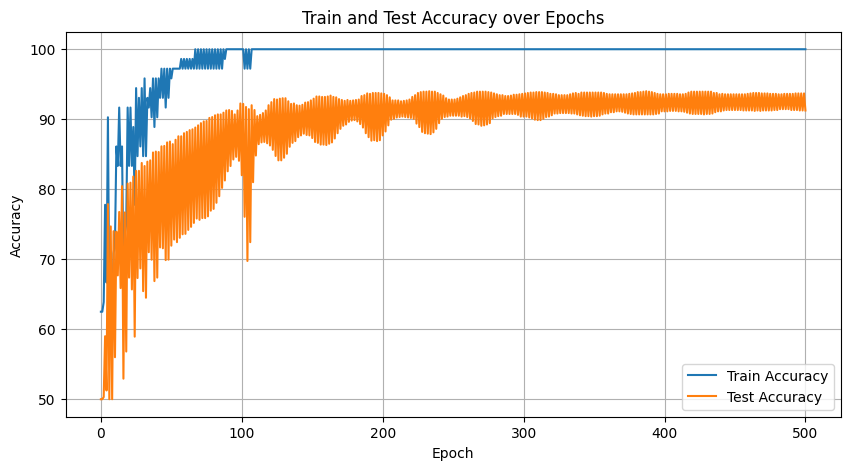

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from numpy.linalg import solve
from tqdm import tqdm
import random
import torch.backends.cudnn as cudnn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define kernel functions here (as provided in your initial code) ...

# Define the neural network architecture
class Nonlinearity(torch.nn.Module):
    def __init__(self):
        super(Nonlinearity, self).__init__()

    def forward(self, x):
        return torch.relu(x)

class Net(nn.Module):
    def __init__(self, dim, num_classes=2):
        super(Net, self).__init__()
        bias = False
        k = 1024
        self.dim = dim
        self.width = k
        self.first = nn.Linear(dim, k, bias=bias)
        self.fc = nn.Sequential(Nonlinearity(),
                                nn.Linear(k, k, bias=bias),
                                Nonlinearity(),
                                nn.Linear(k, num_classes, bias=bias))

    def forward(self, x):
        return self.fc(self.first(x))

# Define training functions here (as provided in your initial code) ...

def one_hot_data(dataset, num_samples=-1):
    labelset = {}
    for i in range(10):
        one_hot = torch.zeros(10)
        one_hot[i] = 1
        labelset[i] = one_hot

    num_samples = int(num_samples)

    if num_samples > 0:
        dataset = torch.utils.data.Subset(dataset, range(num_samples))

    subset = [(ex, label) for idx, (ex, label) in enumerate(dataset)
              if idx < num_samples and (label == 0 or label == 9)]

    adjusted = []
    for idx, (ex, label) in enumerate(subset):
        ex[:, 2:7, 7:12] = 0.
        if label == 9:
            ex[:, 2:7, 7:12] = 1.
        ex = ex.flatten()
        adjusted.append((ex, labelset[label]))

    return adjusted

def split(trainset, p=.8):
    train, val = train_test_split(trainset, train_size=p)
    return train, val

def train_network(train_loader, val_loader, test_loader,
                  num_classes=2, name=None,
                  save_frames=False):
    train_accuracies = []
    test_accuracies = []
    epochs = []

    for idx, batch in enumerate(train_loader):
        inputs, labels = batch
        _, dim = inputs.shape
        break

    net = Net(dim, num_classes=num_classes)
    optimizer = torch.optim.SGD(net.parameters(), lr=.1)
    net.to(device)

    num_epochs = 501
    best_val_acc = 0
    best_test_acc = 0
    best_val_loss = np.inf
    best_test_loss = 0

    for epoch in range(num_epochs):
        train_loss = train_step(net, optimizer, train_loader)
        val_loss = val_step(net, val_loader)
        test_loss = val_step(net, test_loader)
        train_acc = get_acc(net, train_loader)
        val_acc = get_acc(net, val_loader)
        test_acc = get_acc(net, test_loader)

        epochs.append(epoch)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        if val_acc >= best_val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
            torch.save({'state_dict': net.state_dict()}, 'best_model.pth')

        if val_loss <= best_val_loss:
            best_val_loss = val_loss
            best_test_loss = test_loss

        print(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}, Test Acc: {test_acc:.2f}, "
              f"Best Val Acc: {best_val_acc:.2f}, Best Val Loss: {best_val_loss:.4f}, "
              f"Best Test Acc: {best_test_acc:.2f}, Best Test Loss: {best_test_loss:.4f}")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig('accuracy_plot.png')
    plt.show()

# Define the main function and data loaders
def main():
    cudnn.benchmark = True
    global SIZE

    transform = transforms.Compose([transforms.ToTensor()])

    path = '~/datasets/'
    trainset = datasets.STL10(root=path, split='train', transform=transform, download=True)
    trainset = one_hot_data(trainset, num_samples=500)
    trainset, valset = split(trainset, p=.8)

    trainloader = DataLoader(trainset, batch_size=1024, shuffle=True, num_workers=2)
    valloader = DataLoader(valset, batch_size=100, shuffle=False, num_workers=1)

    testset = datasets.STL10(root=path, split='test', transform=transform, download=True)
    testset = one_hot_data(testset, num_samples=1e10)
    testloader = DataLoader(testset, batch_size=1024, shuffle=False, num_workers=2)

    train_network(trainloader, valloader, testloader, num_classes=10, name='grokking')

if __name__ == "__main__":
    main()